# Scatter Plots - ROMY

## Load Libraries

In [1]:
from obspy import UTCDateTime
from scipy.signal import welch
from tqdm import tqdm
from pathlib import Path

import os, sys
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# from andbro__store_as_pickle import __store_as_pickle

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [3]:
## ---------------------------------------

name0 = "FFBI_BDO"

# name1 = "ROMY_BJN"
# name2 = "ROMY_BJE"
# name3 = "ROMY_BJZ"

name1 = "ROMY_BAN"
name2 = "ROMY_BAE"
name3 = "ROMY_BAZ"


In [4]:
# ## ---------------------------------------

config = {}

## specify paths
config['path_to_figs'] = data_path+f"LNM2/figures/scatter/"

config['path_to_data'] = data_path+f"LNM2/data/"

## Methods

In [5]:
def __get_octave_bands(fmin, fmax, fband_type="octave", plot=False):

    """
    Computing octave / one-third-octave bands

    Arguments:
        - fmin:    (float) minimum center frequency
        - fmax:    (float) maximum center frequency
        - fband_type:    [octave] / one-third-octave
        - plot:    (bool) show frequency bands

    Example:

    >>> flower, fupper, fcenter = __get_octave_bands(f_min, f_max, fband_type="octave", plot=False)

    """

    import matplotlib.pyplot as plt
    from numpy import sqrt, array
    from acoustics import bands

    f_lower, f_upper, f_centers = [], [], []

    if fband_type == "octave":
        f_centers = bands.octave(fmin, fmax)
        f_lower = bands.octave_low(fmin, fmax)
        f_upper = bands.octave_high(fmin, fmax)

    if fband_type == "one-third-octave":
        f_centers = bands.third(fmin, fmax)
        f_lower = bands.third_low(fmin, fmax)
        f_upper = bands.third_high(fmin, fmax)

    if plot:
        plt.figure()
        for fl, fc, fu in zip(f_lower, f_centers, f_upper):
            plt.axvline(fu, color="r")
            plt.axvline(fl, color="r")
            plt.axvline(fc)
            plt.axvline(fmin, color="g")
            plt.axvline(fmax, color="g")
            plt.xscale("log")
        plt.show()

    return array(f_lower), array(f_upper), array(f_centers)

In [6]:
def __quantile_regression(x, y, quantiles=[0.05, 0.5, 0.95]):


    from sklearn.utils.fixes import parse_version, sp_version
    from sklearn.linear_model import QuantileRegressor
    from numpy import newaxis, zeros_like, bool_, logical_or, array

    # This is line is to avoid incompatibility if older SciPy version.
    # You should use `solver="highs"` with recent version of SciPy.
    solver = "highs" if sp_version >= parse_version("1.6.0") else "interior-point"

    predictions = {}

    x = array(x)
    X = x[:, newaxis]

    out_bounds_predictions = zeros_like(y, dtype=bool_)

    for quantile in quantiles:
        qr = QuantileRegressor(quantile=quantile, alpha=0, solver=solver)
        y_pred = qr.fit(X, y).predict(X)
        predictions[quantile] = y_pred

        if quantile == min(quantiles):
            out_bounds_predictions = logical_or(
                out_bounds_predictions, y_pred >= y
            )
        elif quantile == max(quantiles):
            out_bounds_predictions = logical_or(
                out_bounds_predictions, y_pred <= y
            )

    print(qr.score(X, y))
    return predictions

In [7]:
def __compute_orthogonal_distance_regression(x_array, y_array, xerr=None, yerr=None, bx=None, by=None):

    from scipy import odr
    from numpy import power, mean, std

    def __model(B, x):
        return 1*x+B[0]

    if bx is None and by is None:
        bx, by = 0, mean(y_array)/mean(x_array)

    if xerr is None and yerr is None:
        xerr, yerr = std(x_array), std(y_array)

#     data = odr.RealData(x_array, y_array)
    data = odr.Data(x_array, y_array, wd=1./xerr, we=1./yerr)

    # odr = odr.ODR(data, model=odr.unilinear)
    M = odr.Model(__model)
    odr = odr.ODR(data, model=M, beta0=[1])

    output = odr.run()

    # slope, intercept = output.beta
    slope, intercept = 1, output.beta[0]

    return slope, intercept

In [8]:
from functions.get_octave_bands import __get_octave_bands

## Plot all 

In [13]:
dat0 = pd.read_pickle(config['path_to_data']+name0+".pkl")

dat1 = pd.read_pickle(config['path_to_data']+name1+".pkl")
dat2 = pd.read_pickle(config['path_to_data']+name2+".pkl")
dat3 = pd.read_pickle(config['path_to_data']+name3+".pkl")

coh1 = pd.read_pickle(config['path_to_data']+name1+"_coherence.pkl")
coh2 = pd.read_pickle(config['path_to_data']+name2+"_coherence.pkl")
coh3 = pd.read_pickle(config['path_to_data']+name3+"_coherence.pkl")


In [12]:
coh3

,dates,0.00103,0.00109,0.00115,0.00122,0.0013,0.00137,0.00145,0.00154,0.00163,...,0.61306,0.64938,0.68786,0.72862,0.77179,0.81752,0.86596,0.91728,0.97163,1.0292


In [66]:
import matplotlib.ticker as mticker

f_lower, f_upper, f_center = __get_octave_bands(1e-3, 1e0, faction_of_octave=12, plot=False)

N_bands = dat0.shape[1] - 1

bands = dat0.keys()[1:]

## compliance
compl = pd.DataFrame()
compl['fl'] = f_lower
compl['fu'] = f_upper
compl['fc'] = f_center

complN, complE, complZ = np.ones(N_bands)*np.nan, np.ones(N_bands)*np.nan, np.ones(N_bands)*np.nan

for _n, band in enumerate(bands):


    if not _n == 13:
        continue

    if pd.isnull(dat0.loc[:, band]).all():
        continue

    _dat0 = dat0.loc[:, ["dates", band]]
    _dat1 = dat1.loc[:, ["dates", band]]
    _dat2 = dat2.loc[:, ["dates", band]]
    _dat3 = dat3.loc[:, ["dates", band]]

    _coh1 = coh1.loc[:, ["dates", band]]
    _coh2 = coh2.loc[:, ["dates", band]]
    _coh3 = coh3.loc[:, ["dates", band]]


    ## join data frames based on dates and hour
    _df1 = pd.merge(left=_dat0, right=_dat1, how="inner", on="dates")
    _df2 = pd.merge(left=_dat0, right=_dat2, how="inner", on="dates")
    _df3 = pd.merge(left=_dat0, right=_dat3, how="inner", on="dates")

    _df1 = pd.merge(left=_df1, right=_coh1, how="inner", on="dates")
    _df2 = pd.merge(left=_df2, right=_coh2, how="inner", on="dates")
    _df3 = pd.merge(left=_df3, right=_coh3, how="inner", on="dates")

    # ## remove NaN values
    _df1.dropna(inplace=True)
    _df2.dropna(inplace=True)
    _df3.dropna(inplace=True)

    ## remove large values
    _df1 = _df1[_df1.iloc[:, 2] < 1e-16]
    _df2 = _df2[_df2.iloc[:, 2] < 1e-16]
    _df3 = _df3[_df3.iloc[:, 2] < 1e-16]

    ## reset the index
    _df1 = _df1.reset_index(drop=True)
    _df2 = _df2.reset_index(drop=True)
    _df3 = _df3.reset_index(drop=True)

    _df1 = _df1.sort_values(by=band, ascending=True)
    _df2 = _df2.sort_values(by=band, ascending=True)
    _df3 = _df3.sort_values(by=band, ascending=True)

    xx1, yy1, ccoh1 = np.log10(_df1.iloc[:, 1]), np.log10(_df1.iloc[:, 2]), _df1.iloc[:, 3]
    xx2, yy2, ccoh2 = np.log10(_df2.iloc[:, 1]), np.log10(_df2.iloc[:, 2]), _df2.iloc[:, 3]
    xx3, yy3, ccoh3 = np.log10(_df3.iloc[:, 1]), np.log10(_df3.iloc[:, 2]), _df3.iloc[:, 3]

#     try:
#         pre1 = __quantile_regression(xx1, yy1, quantiles=[0.01, 0.5, 0.99])
#         pre2 = __quantile_regression(xx2, yy2, quantiles=[0.01, 0.5, 0.99])
#         pre3 = __quantile_regression(xx3, yy3, quantiles=[0.01, 0.5, 0.99])

#     except Exception as e:
#         print(e)
#         pass

    ## only select high coherence (=hc)
    coh_thres = 0.8
    df1_hc = _df1_high_coh = _df1[_df1.iloc[:, 3] > coh_thres]
    df2_hc = _df2_high_coh = _df2[_df2.iloc[:, 3] > coh_thres]
    df3_hc = _df3_high_coh = _df3[_df3.iloc[:, 3] > coh_thres]

    xx1_hc, yy1_hc = np.log10(df1_hc.iloc[:, 1]), np.log10(df1_hc.iloc[:, 2])
    xx2_hc, yy2_hc = np.log10(df2_hc.iloc[:, 1]), np.log10(df2_hc.iloc[:, 2])
    xx3_hc, yy3_hc = np.log10(df3_hc.iloc[:, 1]), np.log10(df3_hc.iloc[:, 2])


    try:
        if len(xx1_hc) >= 10:
            odr1_slope, odr1_inter = __compute_orthogonal_distance_regression(xx1_hc, yy1_hc, xerr=None, yerr=None, bx=None, by=None)
        else:
            odr1_slope, odr1_inter = np.nan, np.nan
        if len(xx2_hc) >= 10:
            odr2_slope, odr2_inter = __compute_orthogonal_distance_regression(xx2_hc, yy2_hc, xerr=None, yerr=None, bx=None, by=None)
        else:
            odr2_slope, odr2_inter = np.nan, np.nan
        if len(xx3_hc) >= 10:
            odr3_slope, odr3_inter = __compute_orthogonal_distance_regression(xx3_hc, yy3_hc, xerr=None, yerr=None, bx=None, by=None)
        else:
            odr3_slope, odr3_inter = np.nan, np.nan
        try:
            complN[_n] = odr1_inter
        except:
            complN[_n] = np.nan
        try:
            complE[_n] = odr2_inter
        except:
            complE[_n] = np.nan
        try:
            complZ[_n] = odr3_inter
        except:
            complZ[_n] = np.nan

    except Exception as e:
        complN[_n], complE[_n], complZ[_n] = np.nan, np.nan, np.nan
        print(e)
        pass


    ## ____________________________________________________________________

    fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

    font = 12

    cmap = plt.colormaps.get("viridis")
    cmap = plt.get_cmap("viridis", 10)

    plt.subplots_adjust(wspace=0.12)

    ca1 = ax[0].scatter(10**xx1, 10**yy1, s=15, c=ccoh1, edgecolors="black", lw=0.5, zorder=2, cmap=cmap, vmin=0., vmax=1)
    ca2 = ax[1].scatter(10**xx2, 10**yy2, s=15, c=ccoh2, edgecolors="black", lw=0.5, zorder=2, cmap=cmap, vmin=0., vmax=1)
    ca3 = ax[2].scatter(10**xx3, 10**yy3, s=15, c=ccoh3, edgecolors="black", lw=0.5, zorder=2, cmap=cmap, vmin=0., vmax=1)

#     try:
#         ax[0].plot(10**xx1, 10**pre1[0.01], color="k", zorder=1, ls=":", label="90%-fit")
#         ax[1].plot(10**xx2, 10**pre2[0.01], color="k", zorder=1, ls=":", label="90%-fit")
#         ax[2].plot(10**xx3, 10**pre3[0.01], color="k", zorder=1, ls=":", label="90%-fit")
#     except Exception as e:
#         print(e)
#         pass

    ## add correlation estimate
    _xx = np.logspace(-10, 10, 100)
    _yy = 1e-22 * _xx

    # ax[0].plot(_xx, _yy + _xx*1e-17, color="darkred", ls="--", label="1 $m^2/s^4/Pa^2$")
    # ax[1].plot(_xx, _yy + _xx*1e-17, color="darkred", ls="--", label="1 $m^2/s^4/Pa^2$")
    # ax[2].plot(_xx, _yy + _xx*1e-19, color="darkred", ls="--", label="1 $m^2/s^4/Pa^2$")

    try:
        _xx = np.linspace(-10, 10, 100)
        for _i, (slope, intercept) in enumerate(zip([odr1_slope, odr2_slope, odr3_slope], [odr1_inter, odr2_inter, odr3_inter])):
            ax[_i].plot(10**(_xx), 10**(_xx*slope+intercept), color="red", ls="--", label=f"{round(slope,3)} $rad^2/s^2/Pa^2$")
            # ax[_i].plot(10**(_xx), 10**(_xx*1+intercept), color="red", ls="--", label=f"{round(slope,3)} $m^2/s^4/Pa^2$")
    except Exception as e:
        print(e)
        pass

    for _i in range(3):
        ax[_i].set_xscale("log")
        ax[_i].set_yscale("logit")
        ax[_i].set_xlim(1e-2, 1e7)
        ax[_i].set_ylim(1e-23, 1e-8)
        ax[_i].grid(zorder=0, alpha=0.5, which="both")
        ax[_i].legend(loc=2)
        ax[_i].set_xlabel(r"PSD (Pa$^2$ /Hz)", fontsize=font)

        ax[_i].xaxis.set_major_locator(mticker.LogLocator(numticks=999))
        ax[_i].xaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))

    # ax[0].set_title(f"{name0.replace('_','-')} & {name1.replace('_','-')} | fc = {float(_df1.keys()[1][:-2])*1e3} mHz")
    # ax[1].set_title(f"{name0.replace('_','-')} & {name2.replace('_','-')} | fc = {float(_df2.keys()[1][:-2])*1e3} mHz")
    # ax[2].set_title(f"{name0.replace('_','-')} & {name3.replace('_','-')} | fc = {float(_df3.keys()[1][:-2])*1e3} mHz")
    ax[0].set_title(f"{name0.replace('_','-')} & {name1.replace('_','-')} | {round(f_lower[_n]*1e3, 1)} - {round(f_upper[_n]*1e3, 1)} mHz")
    ax[1].set_title(f"{name0.replace('_','-')} & {name2.replace('_','-')} | {round(f_lower[_n]*1e3, 1)} - {round(f_upper[_n]*1e3, 1)} mHz")
    ax[2].set_title(f"{name0.replace('_','-')} & {name3.replace('_','-')} | {round(f_lower[_n]*1e3, 1)} - {round(f_upper[_n]*1e3, 1)} mHz")

    ax[0].text(.8, .04, f"N={len(xx1)}", ha='left', va='top', transform=ax[0].transAxes, fontsize=font)
    ax[1].text(.8, .04, f"N={len(xx2)}", ha='left', va='top', transform=ax[1].transAxes, fontsize=font)
    ax[2].text(.8, .04, f"N={len(xx3)}", ha='left', va='top', transform=ax[2].transAxes, fontsize=font)

    ax[0].set_ylabel(r"PSD (rad$^2$ /s$^2$ /Hz)", fontsize=font)

    ## add colorbar
    cbar_ax = fig.add_axes([0.92, 0.11, 0.01, 0.77]) #[left, bottom, width, height]
    cb = plt.colorbar(ca1, cax=cbar_ax)
    cb.set_label("Coherence", fontsize=font, labelpad=-50, color="black")

    plt.show();

    fig.savefig(config['path_to_figs']+f"all/{str(_n).rjust(3, '0')}_{name1}_{name2}_{band}Hz_all.png", format="png", dpi=200, bbox_inches='tight');



ValueError: You are trying to merge on object and float64 columns. If you wish to proceed you should use pd.concat

In [13]:
# f_lower, f_upper, f_center = __get_octave_bands(1e-3, 1e0, faction_of_octave=12, plot=False)

# N_bands = dat0.shape[1] - 1

# bands = dat0.keys()[1:]

# ## compliance
# compl = pd.DataFrame()
# compl['fl'] = f_lower
# compl['fu'] = f_upper
# compl['fc'] = f_center

# complU, complV, complZ = np.ones(N_bands)*np.nan, np.ones(N_bands)*np.nan, np.ones(N_bands)*np.nan


# for _n, band in enumerate(bands):

#     # if not _n == 13:
#     #     continue

#     _dat0 = dat0.loc[:, ["dates", band]]
#     _dat1 = dat1.loc[:, ["dates", band]]
#     _dat2 = dat2.loc[:, ["dates", band]]
#     _dat3 = dat3.loc[:, ["dates", band]]

#     _coh1 = coh1.loc[:, ["dates", band]]
#     _coh2 = coh2.loc[:, ["dates", band]]
#     _coh3 = coh3.loc[:, ["dates", band]]

#     ## join data frames based on dates and hour
#     _df1 = pd.merge(left=_dat0, right=_dat1, how="inner", on="dates")
#     _df2 = pd.merge(left=_dat0, right=_dat2, how="inner", on="dates")
#     _df3 = pd.merge(left=_dat0, right=_dat3, how="inner", on="dates")

#     _df1 = pd.merge(left=_df1, right=_coh1, how="inner", on="dates")
#     _df2 = pd.merge(left=_df2, right=_coh2, how="inner", on="dates")
#     _df3 = pd.merge(left=_df3, right=_coh3, how="inner", on="dates")

#     # ## remove NaN values
#     _df1.dropna(inplace=True)
#     _df2.dropna(inplace=True)
#     _df3.dropna(inplace=True)

#     ## remove large values
#     _df1 = _df1[_df1.iloc[:, 2] < 1e-15]
#     _df2 = _df2[_df2.iloc[:, 2] < 1e-15]
#     _df3 = _df3[_df3.iloc[:, 2] < 1e-15]

#     ## reset the index
#     _df1 = _df1.reset_index(drop=True)
#     _df2 = _df2.reset_index(drop=True)
#     _df3 = _df3.reset_index(drop=True)

#     _df1 = _df1.sort_values(by=band, ascending=True)
#     _df2 = _df2.sort_values(by=band, ascending=True)
#     _df3 = _df3.sort_values(by=band, ascending=True)

#     xx1, yy1, ccoh1 = np.log10(_df1.iloc[:, 1]), np.log10(_df1.iloc[:, 2]), _df1.iloc[:, 3]
#     xx2, yy2, ccoh2 = np.log10(_df2.iloc[:, 1]), np.log10(_df2.iloc[:, 2]), _df2.iloc[:, 3]
#     xx3, yy3, ccoh3 = np.log10(_df3.iloc[:, 1]), np.log10(_df3.iloc[:, 2]), _df3.iloc[:, 3]


#     ## only select high coherence (=hc)
#     coh_thres = 0.8
#     df1_hc = _df1_high_coh = _df1[_df1.iloc[:, 3] > coh_thres]
#     df2_hc = _df2_high_coh = _df2[_df2.iloc[:, 3] > coh_thres]
#     df3_hc = _df3_high_coh = _df3[_df3.iloc[:, 3] > coh_thres]

#     xx1_hc, yy1_hc = np.log10(df1_hc.iloc[:, 1]), np.log10(df1_hc.iloc[:, 2])
#     xx2_hc, yy2_hc = np.log10(df2_hc.iloc[:, 1]), np.log10(df2_hc.iloc[:, 2])
#     xx3_hc, yy3_hc = np.log10(df3_hc.iloc[:, 1]), np.log10(df3_hc.iloc[:, 2])


#     try:
#         if len(xx1_hc) >= 10:
#             odr1_slope, odr1_inter = __compute_orthogonal_distance_regression(xx1_hc, yy1_hc, xerr=None, yerr=None, bx=None, by=None)
#         else:
#             odr1_slope = np.nan
#         if len(xx2_hc) >= 10:
#             odr2_slope, odr2_inter = __compute_orthogonal_distance_regression(xx2_hc, yy2_hc, xerr=None, yerr=None, bx=None, by=None)
#         else:
#             odr2_slope = np.nan
#         if len(xx3_hc) >= 10:
#             odr3_slope, odr3_inter = __compute_orthogonal_distance_regression(xx3_hc, yy3_hc, xerr=None, yerr=None, bx=None, by=None)
#         else:
#             odr3_slope = np.nan

#         complU[_n], complV[_n], complZ[_n] = np.sqrt(odr1_slope), np.sqrt(odr2_slope), np.sqrt(odr3_slope)

#     except Exception as e:
#         complU[_n], complV[_n], complZ[_n] = np.nan, np.nan, np.nan
#         print(e)
#         pass

# #     try:
# #         pre1 = __quantile_regression(xx1_hc, yy1_hc, quantiles=[0.05, 0.5, 0.95])
# #         pre2 = __quantile_regression(xx2_hc, yy2_hc, quantiles=[0.05, 0.5, 0.95])
# #         pre3 = __quantile_regression(xx3_hc, yy3_hc, quantiles=[0.05, 0.5, 0.95])
# #     except Exception as e:
# #         print(e)
# #         pass


#     ## ____________________________________________________________________

#     fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

#     font = 12

#     cmap = plt.colormaps.get("viridis")

#     plt.subplots_adjust(wspace=0.12)

#     # ca1 = ax[0].scatter(10**xx1, 10**yy1, s=15, c=ccoh1, alpha=ccoh1, edgecolors="black", lw=0.5, zorder=2, cmap=cmap, vmin=0, vmax=1)
#     # ca2 = ax[1].scatter(10**xx2, 10**yy2, s=15, c=ccoh2, alpha=ccoh2, edgecolors="black", lw=0.5, zorder=2, cmap=cmap, vmin=0, vmax=1)
#     # ca3 = ax[2].scatter(10**xx3, 10**yy3, s=15, c=ccoh3, alpha=ccoh3, edgecolors="black", lw=0.5, zorder=2, cmap=cmap, vmin=0, vmax=1)
#     ca1 = ax[0].scatter(10**xx1, 10**yy1, s=15, c=ccoh1, edgecolors="black", lw=0.5, zorder=2, cmap=cmap, vmin=0, vmax=1)
#     ca2 = ax[1].scatter(10**xx2, 10**yy2, s=15, c=ccoh2, edgecolors="black", lw=0.5, zorder=2, cmap=cmap, vmin=0, vmax=1)
#     ca3 = ax[2].scatter(10**xx3, 10**yy3, s=15, c=ccoh3, edgecolors="black", lw=0.5, zorder=2, cmap=cmap, vmin=0, vmax=1)

# #     try:
# #         ax[0].plot(10**xx1_hc, 10**pre1[0.05], color="pink", zorder=3, ls=":", label="95%-fit")
# #         ax[1].plot(10**xx2_hc, 10**pre2[0.05], color="pink", zorder=3, ls=":", label="95%-fit")
# #         ax[2].plot(10**xx3_hc, 10**pre3[0.05], color="pink", zorder=3, ls=":", label="95%-fit")

# #     except Exception as e:
# #         print(e)
# #         pass

#     ## add correlation estimate
#     _xx = np.logspace(-2, 7)
#     _yy = 1e-22 * _xx

#     for _i in range(3):
#         ax[_i].plot(_xx, _yy, color="darkred", ls="--", label="1 nrad/s/Pa")

#     try:
#         _xx = np.linspace(-10, 10, 100)
#         for _i, (slope, intercept) in enumerate(zip([odr1_slope, odr2_slope, odr3_slope], [odr1_inter, odr2_inter, odr3_inter])):
#             ax[_i].plot(10**(_xx), 10**(_xx*slope+intercept), color="red", ls="--", label=f"{round(slope,3)} $m^2/s^4/Pa^2$")
#     except:
#         pass



#     for _i in range(3):
#         ax[_i].set_xscale("log")
#         ax[_i].set_yscale("log")
#         ax[_i].set_xlim(1e-3, 1e7)
#         ax[_i].set_ylim(1e-23, 1e-15)
#         ax[_i].grid(zorder=0, alpha=0.5)
#         ax[_i].legend(loc=2)
#         ax[_i].set_xlabel(r"PSD (Pa$^2$ /Hz)", fontsize=font)

#     # ax[0].set_title(f"{name0.replace('_','-')} & {name1.replace('_','-')} | fc = {float(_df1.keys()[1][:-2])*1e3} mHz")
#     # ax[1].set_title(f"{name0.replace('_','-')} & {name2.replace('_','-')} | fc = {float(_df2.keys()[1][:-2])*1e3} mHz")
#     # ax[2].set_title(f"{name0.replace('_','-')} & {name3.replace('_','-')} | fc = {float(_df3.keys()[1][:-2])*1e3} mHz")
#     ax[0].set_title(f"{name0.replace('_','-')} & {name1.replace('_','-')} | {round(f_lower[_n]*1e3, 1)} - {round(f_upper[_n]*1e3, 1)} mHz")
#     ax[1].set_title(f"{name0.replace('_','-')} & {name2.replace('_','-')} | {round(f_lower[_n]*1e3, 1)} - {round(f_upper[_n]*1e3, 1)} mHz")
#     ax[2].set_title(f"{name0.replace('_','-')} & {name3.replace('_','-')} | {round(f_lower[_n]*1e3, 1)} - {round(f_upper[_n]*1e3, 1)} mHz")

#     ax[0].text(.8, .04, f"N={len(xx1)}", ha='left', va='top', transform=ax[0].transAxes, fontsize=font)
#     ax[1].text(.8, .04, f"N={len(xx2)}", ha='left', va='top', transform=ax[1].transAxes, fontsize=font)
#     ax[2].text(.8, .04, f"N={len(xx3)}", ha='left', va='top', transform=ax[2].transAxes, fontsize=font)

#     ax[0].set_ylabel(r"PSD (rad$^2$ /s$^2$ /Hz)", fontsize=font)

#     ## add colorbar
#     cbar_ax = fig.add_axes([0.92, 0.11, 0.01, 0.77]) #[left, bottom, width, height]
#     cb = plt.colorbar(ca1, cax=cbar_ax)
#     cb.set_label("Coherence", fontsize=font, labelpad=-50, color="black")

#     plt.show();

#     fig.savefig(config['path_to_figs']+f"all/{str(_n).rjust(3, '0')}_{name1}_{name2}_{band}Hz_all.png", format="png", dpi=200, bbox_inches='tight');


In [14]:
compl['N'] = np.sqrt(10**complN)
compl['E'] = np.sqrt(10**complE)
compl['Z'] = np.sqrt(10**complZ)

## Compliance Plot

In [15]:
def __makeplot():

    Nrow, Ncol = 1, 1

    font = 12

    scaling = 1e9

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(10, 5))

    ax.plot(compl['fc'], compl['N']*scaling, label=f"{name1[:-2]}.{name1[-1]}")
    ax.plot(compl['fc'], compl['E']*scaling, label=f"{name2[:-2]}.{name2[-1]}")
    ax.plot(compl['fc'], compl['Z']*scaling, label=f"{name3[:-2]}.{name3[-1]}")

    ax.grid(ls=":", zorder=0)
    ax.legend(loc=1)

    ax.set_xscale("log")
    # ax.set_yscale("log")

    ax.set_xlim(1e-3, 1e0)
    # ax.set_ylim(0.5, 2)

    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Compliance (nrad/s/Pa)")

    plt.show();
    return fig

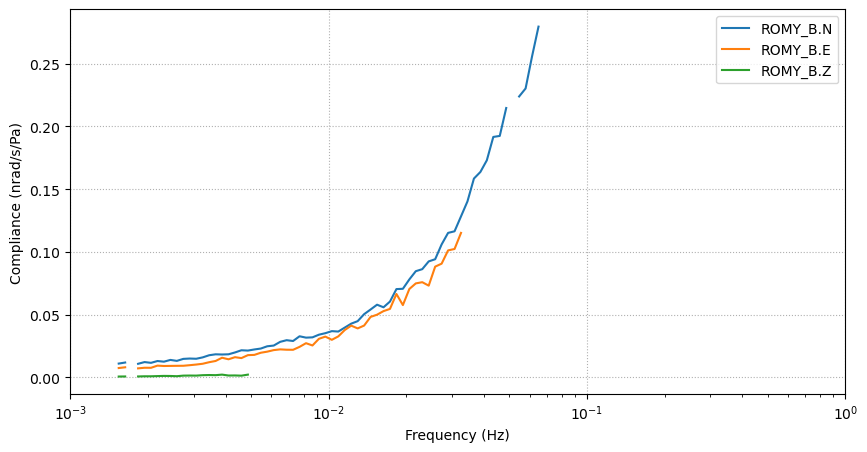

In [16]:
# compl = compl.replace(1.0, np.nan)

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"ROMY_ZNE_compliance.png", format="png", dpi=200, bbox_inches='tight')

In [17]:
os.system("""spd-say "Finished" """)

0